In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install wandb -qU
%pip install --no-deps scikeras
%pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.0 MB/s eta 0:00:00


In [3]:
#imports
import os
import wandb
from wandb.keras import WandbCallback
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
import tensorflow_addons as tfa
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.optimizers import SGD
from keras.layers import Dropout

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Data processing **

In [ ]:
# #GPU search and selection
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#     try:
#         # Use the first GPU
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)
# else:
#     print('No GPU detected')

In [4]:
#-----------------------------------------------------------------------------------------------------------
#Upload Real Datasets
df_real1 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/RealData/Blue Order 1 (Ready_4ML).csv')
df_real2 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/RealData/Red Order 1 (REady_4ML).csv')
df_real3 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/RealData/White Order 1 (Ready_4ML).csv')

df_real1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df_real2.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df_real3.rename(columns={'Run Time ': 'Run Time'}, inplace=True)


# Concatenating Real Datasets (Assuming df_real1, df_real2, and df_real3 are separate DataFrames)

# Concatenate df_real2 and df_real3 first
concatenated_df = pd.concat([df_real2, df_real3])

# Now, concatenate df_real1 with the previously concatenated DataFrame
df2 = pd.concat([df_real1, concatenated_df])

# Alternatively, you can concatenate all DataFrames in one line
df2 = pd.concat([df_real1, df_real2, df_real3])

#uncomment below print statements to see exactly what steps are followed
#################################################
#print("combined real dataset", '\n' ,df2)
#################################################

#-----------------------------------------------------------------------------------------------------------
#Upload Simulated Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/mergedata/RWB_SimDataCombined.csv')

# Rename the 'B' column to 'C' in-place
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)

#Create a TARGET[LABEL] column
df1['type'] = 0 #SimData
df2['type'] = 1 #RealData
df_combined = pd.concat([df1, df2])

# Removing any extra spaces in the topics column
df_combined['topics'] = df_combined['topics'].apply(lambda x: x.replace(" ", ""))

#################################################
#print("combined Real & simulated dataset", '\n', df_combined)
#################################################

#-----------------------------------------------------------------------------------------------------------
# label_encoder
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'topics', 'msg', and 'node'.
df_combined['topics']= label_encoder.fit_transform(df_combined['topics'])
df_combined['msg']= label_encoder.fit_transform(df_combined['msg'])
df_combined['node']= label_encoder.fit_transform(df_combined['node'])

#################################################
#print("combined dataset [encoded]", '\n', df_combined)
#################################################

#-----------------------------------------------------------------------------------------------------------
#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df_combined.drop(predict, axis=1)
y = df_combined[predict]
print(X.head())
print(y.head())

#-----------------------------------------------------------------------------------------------------------\
#Train,test,split setup 70-30
X_train, X_test, y_train, y_test =  sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)

print(f'Train y: {y_train.shape}')
print(f'Train X: {X_train.shape}')
print(f'Test y: {y_test.shape}')
print(f'Test X: {X_test.shape}')

    Run Time  msg  node  topics
0   0.000000   25     0       4
1   0.235499   37     7       2
2   0.288815   39     7       2
3   0.300417   21     1       0
4  18.445745   14     1       0
0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64
Train y: (159,)
Train X: (159, 4)
Test y: (69,)
Test X: (69, 4)


--------------------------
Weights and Biases Setup
--------------------------

In [5]:
#This cell will run continuously until an API key is pasted into an input box.
#If the input box does not show, cancel the cell and move on to the next where the same prompt will arise with an input box.
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
#Define the notebook name for WandB sweep
#os.environ["WANDB_NOTEBOOK_NAME"] = "TuringTest_ML(7_11_23) 5HLBayes.ipynb"

# Sweep configuration
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize',
        'name': 'f1_score'
		},
    'parameters': {
        'batch_size': {'values': [10,15,25,32,50,64,75,100]},
        'epochs': {'values': [50,75,100,125,150,200,250,300]},
        'fc_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'sc_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'Td_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'Frth_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'Fif_layer_size': {'values': [7,9,11,13,15,20,25,30,50]},
        'lr': {'max': 0.1, 'min': 0.0001},
        'optimizer':{'values': ['adam','SGD','RMSprop','nadam','Adadelta','Adagrad','Adamax','Ftrl','AdamW']},
        'dropout': {'values': [0, 0.3, 0.5]},
     },

}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="NN_Turing", entity="dt_zach")

Create sweep with ID: 1m3s8jjt
Sweep URL: https://wandb.ai/dt_zach/NN_Turing/sweeps/1m3s8jjt


In [7]:
#defining which optimizers the sweep will attempt to use

def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)
    if optimizer.lower() == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    if optimizer.lower() == "nadam":
        return tf.keras.optimizers.Nadam(learning_rate=lr)
    if optimizer.lower() == "adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=lr)
    if optimizer.lower() == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    if optimizer.lower() == "adamax":
        return tf.keras.optimizers.Adamax(learning_rate=lr)
    if optimizer.lower() == "ftrl":
        return tf.keras.optimizers.Ftrl(learning_rate=lr)
    if optimizer.lower() == "adamw":
        return tf.keras.optimizers.AdamW(learning_rate=lr)

    #define the initial NN for parameter sweep
#-----------------------------------------------------------------------------------------------------------
def Nerual_Net(fc_layer_size=11,sc_layer_size=7,Td_layer_size=7,Frth_layer_size=7,Fif_layer_size=7,dropout=0):
# Set the GPU as the backend for Keras
  config = tf.compat.v1.ConfigProto()
  config.gpu_options.allow_growth = True
  sess = tf.compat.v1.Session(config=config)
  tf.compat.v1.keras.backend.set_session(sess)
  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation
  network.add(Dense(4, input_dim=4, activation="relu",use_bias=True,bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))

  #hiddent layers
  network.add(Dense(fc_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  # 2nd hiddent layers
  network.add(Dense(sc_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  # 3rd hiddent layers
  network.add(Dense(Td_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  # 4th hidden layers
  network.add(Dense(Frth_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(dropout))
  #fifth hidden layers
  network.add(Dense(Fif_layer_size, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))


  #Output layer that is fully connected with sigmoid activation
  network.add(Dense(1, activation="sigmoid",kernel_initializer="glorot_normal"))


  #return completed network
  return network

#define the training behavior for the sweep
#-----------------------------------------------------------------------------------------------------------
def train(model, batch_size=64, epochs=10, lr=1e-3, optimizer='adam', log_freq=10):

    # Compile model like you usually do.
    tf.keras.backend.clear_session()
    model.compile(optimizer=get_optimizer(lr, optimizer) ,
               loss="binary_crossentropy",
               metrics=["binary_accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='micro',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=True)
                        ])

    model.fit(X_train,
              y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              callbacks=[WandbCallback()])

    #More sweep configuirations for training
#-----------------------------------------------------------------------------------------------------------
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "TestLabfab"
        wandb.config.dataset_name = "Labfab"

        # initialize model
        model = Nerual_Net(wandb.config.fc_layer_size,wandb.config.sc_layer_size,wandb.config.Td_layer_size,wandb.config.Frth_layer_size,wandb.config.Fif_layer_size,wandb.config.dropout)

        train(model,
              wandb.config.batch_size,
              wandb.config.epochs,
              wandb.config.lr,
              wandb.config.optimizer)

In [8]:
#Sanity check
import pprint
pprint.pprint(sweep_configuration)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'f1_score'},
 'name': 'sweep',
 'parameters': {'Fif_layer_size': {'values': [7,
                                              9,
                                              11,
                                              13,
                                              15,
                                              20,
                                              25,
                                              30,
                                              50]},
                'Frth_layer_size': {'values': [7,
                                               9,
                                               11,
                                               13,
                                               15,
                                               20,
                                               25,
                                               30,
                                               50]},


In [9]:
#Sweep initialization for 150 combinations of parameters
wandb.agent(sweep_id, function=sweep_train, count=150)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
run = wandb.init(project="NN_Turing", entity="dt_zach")

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Testing the best model from Wandb Sweep

In [11]:
#Build the model
def Neural_Net():

  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation
  network.add(Dense(4, input_dim=4, activation="relu",use_bias=True,bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0.5))
  #hidden layers
  network.add(Dense(50, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0.5))
  network.add(Dense(11, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0.5))
  network.add(Dense(30, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0.5))
  network.add(Dense(50, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
  network.add(Dropout(0.5))
  network.add(Dense(50, activation="relu", use_bias=True, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))

  #Output layer that is fully connected with sigmoid activation
  network.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))


  # Compile network model.
  network.compile(optimizer=get_optimizer(0.02434, 'SGD'),
               loss="binary_crossentropy",
               metrics=["binary_accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='micro',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=False)
                        ])


  #return completed network
  return network

# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(
                                 model=Neural_Net,
                                 epochs=200,
                                 batch_size=32,
                                 verbose=0,
                                 callbacks=[WandbCallback()]
                                 )

---------------------------------------------------------------------------------------------------------------------
K_fold (Post-sweep) to provide a more robust evaluation of the model's performance and its ability to generalize to unseen data.

In [12]:
#Setup stratified Kfold for cross validation
seed = 123457
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [13]:
#shows how good the model is
predictions = cross_val_predict(neural_network, X_train, y_train, cv=kfold)

[[ 7 69]
 [ 9 74]] 



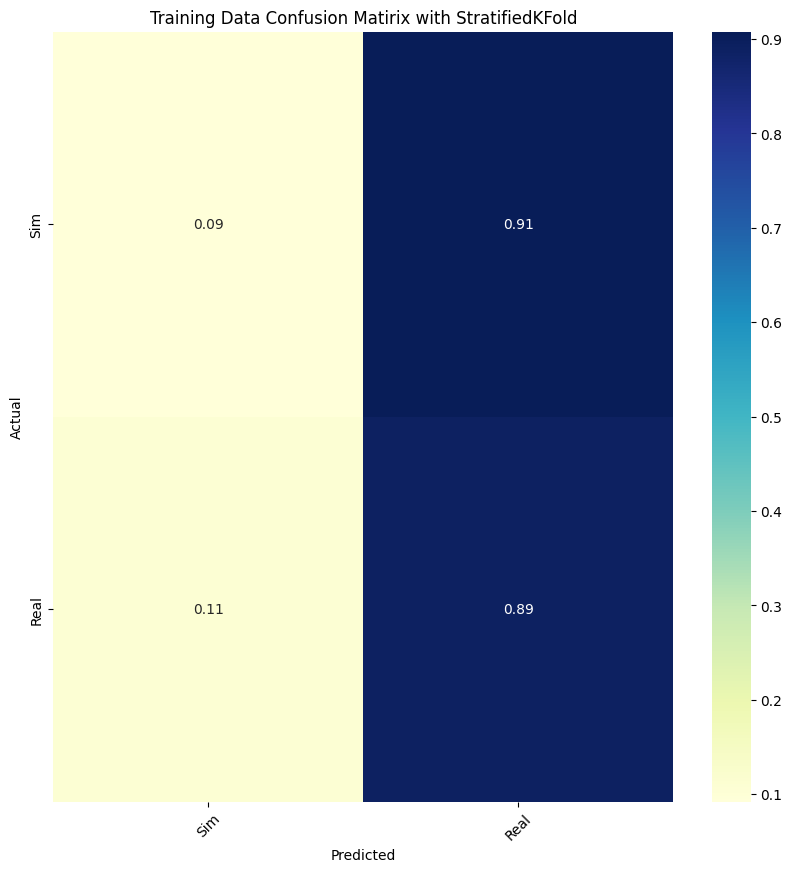


F1 Score: 0.6548672566371682
Precision: 0.5174825174825175
Recall: 0.891566265060241
Accuracy: 0.5094339622641509


In [16]:
#Training Data Confusion Matirix (W/ Kfold CV)
#-----------------------------------------------------------------------------------------------------------
conf_matrix = confusion_matrix(y_train, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Data Confusion Matirix with StratifiedKFold')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, predictions, average='binary')))
print('Precision: {}'.format(
    precision_score(y_train, predictions, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, predictions, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, predictions)))

Test data confrimation

In [17]:
model = Neural_Net()
#Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=100, callbacks=[WandbCallback()])
test_pred = model.predict(X_test)


Epoch 1/300
1/2 [==============>...............] - ETA: 1s - loss: 0.6882 - binary_accuracy: 0.5200 - f1_score: 0.6066 - auc_10: 0.4833

wandb: Adding directory to artifact (/content/wandb/run-20230728_183054-7gqn48xe/files/model-best)... Done. 0.0s


2/2 [==============================] - 3s 2s/step - loss: 0.6895 - binary_accuracy: 0.5220 - f1_score: 0.5914 - auc_10: 0.5079 - val_loss: 0.6998 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4932
Epoch 2/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6744 - binary_accuracy: 0.5600 - f1_score: 0.6207 - auc_10: 0.5811

wandb: Adding directory to artifact (/content/wandb/run-20230728_183054-7gqn48xe/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6736 - binary_accuracy: 0.6038 - f1_score: 0.6631 - auc_10: 0.6299 - val_loss: 0.6997 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4932
Epoch 3/300
1/2 [==============>...............] - ETA: 0s - loss: 0.6911 - binary_accuracy: 0.4700 - f1_score: 0.5827 - auc_10: 0.5244

wandb: Adding directory to artifact (/content/wandb/run-20230728_183054-7gqn48xe/files/model-best)... Done. 0.0s


2/2 [==============================] - 2s 2s/step - loss: 0.6929 - binary_accuracy: 0.4906 - f1_score: 0.6010 - auc_10: 0.5185 - val_loss: 0.6993 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4958
Epoch 4/300
1/2 [==============>...............] - ETA: 0s - loss: 0.7034 - binary_accuracy: 0.4700 - f1_score: 0.5391 - auc_10: 0.4350

wandb: Adding directory to artifact (/content/wandb/run-20230728_183054-7gqn48xe/files/model-best)... Done. 0.0s


2/2 [==============================] - 3s 3s/step - loss: 0.7002 - binary_accuracy: 0.4843 - f1_score: 0.5543 - auc_10: 0.4758 - val_loss: 0.6993 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4958
Epoch 5/300
2/2 [==============================] - 0s 54ms/step - loss: 0.6985 - binary_accuracy: 0.4906 - f1_score: 0.5714 - auc_10: 0.4812 - val_loss: 0.6996 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4958
Epoch 6/300
2/2 [==============================] - 0s 51ms/step - loss: 0.7080 - binary_accuracy: 0.4591 - f1_score: 0.5326 - auc_10: 0.4321 - val_loss: 0.6998 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4958
Epoch 7/300
2/2 [==============================] - 0s 50ms/step - loss: 0.6874 - binary_accuracy: 0.4780 - f1_score: 0.5202 - auc_10: 0.5362 - val_loss: 0.6999 - val_binary_accuracy: 0.4493 - val_f1_score: 0.6200 - val_auc_10: 0.4958
Epoch 8/300
2/2 [==============================] - 0s 45ms/step - loss: 0.7065

5/5 [==============================] - 0s 2ms/step
[[ 0 76]
 [ 0 83]] 



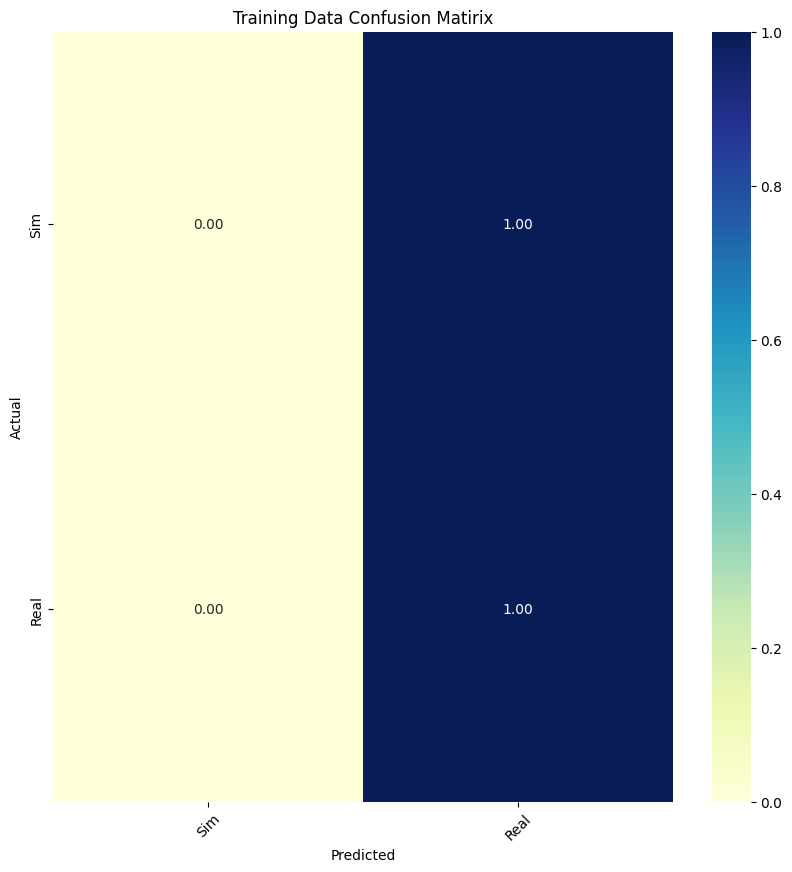


F1 Score: 0.6859504132231404
Precision: 0.5220125786163522
Recall: 1.0
Accuracy: 0.5220125786163522


In [18]:
#Training Data Confusion Matirix
#-----------------------------------------------------------------------------------------------------------
predictions = (model.predict(X_train) > 0.5).astype("int32")


conf_matrix = confusion_matrix(y_train, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Data Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, predictions, average='binary')))
print('Precision: {}'.format(
    precision_score(y_train, predictions, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, predictions, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, predictions)))

3/3 [==============================] - 0s 2ms/step
[[ 0 38]
 [ 0 31]] 



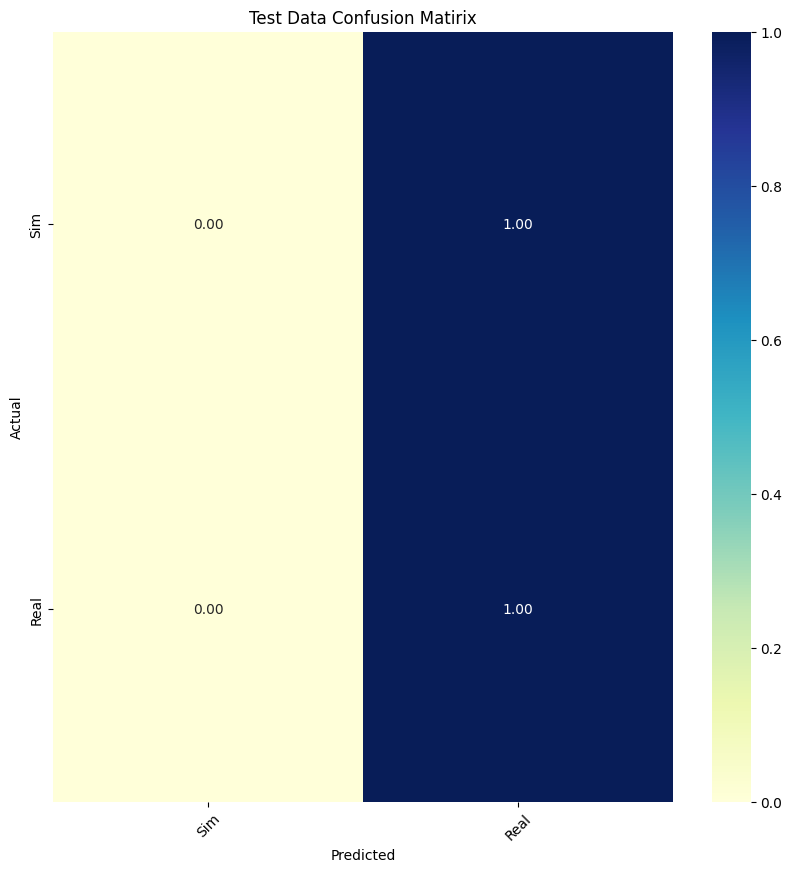


F1 Score: 0.62
Precision: 0.4492753623188406
Recall: 1.0
Accuracy: 0.4492753623188406


In [19]:
#Test Data Confusion Matirix
#-----------------------------------------------------------------------------------------------------------
predictions_test = (model.predict(X_test) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, predictions_test)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test Data Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test, predictions_test, average='binary')))
print('Precision: {}'.format(
    precision_score(y_test, predictions_test, average='binary'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test, predictions_test, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_test, predictions_test)))

In [20]:
model.layers[0].get_weights()[1]

array([-0.02718459,  0.6678271 ,  0.43635944,  0.5766604 ], dtype=float32)

[[38  0]
 [31  0]] 



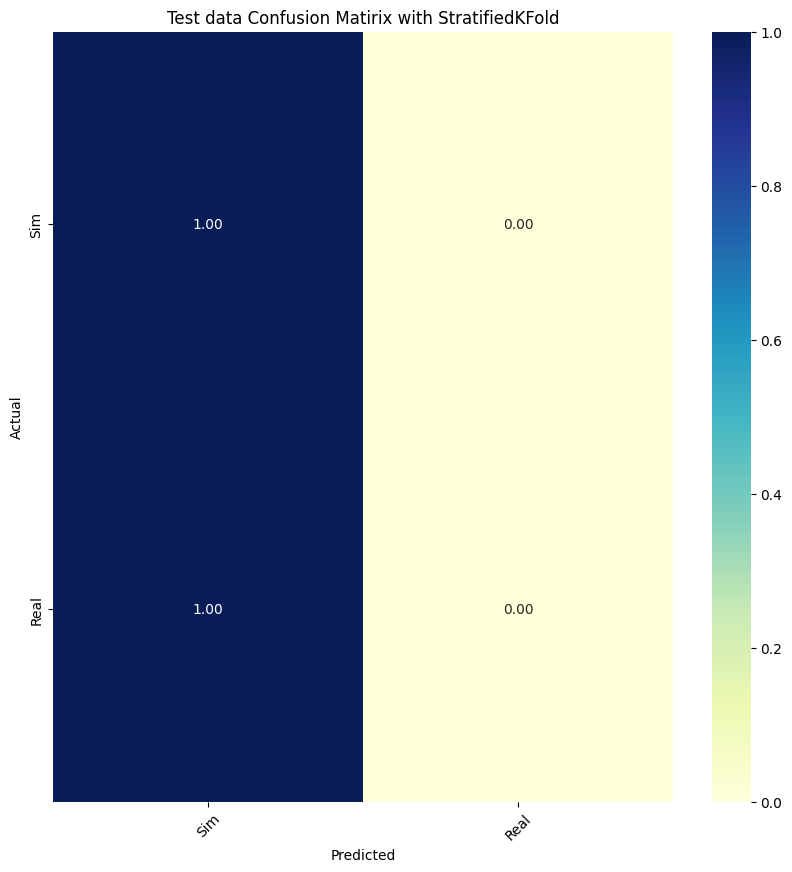


F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.5507246376811594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
#Test Data Confusion Matirix (w/ Kfold CV)
#-----------------------------------------------------------------------------------------------------------

#Test data with Kfold CV (shows how good the model is)
predictions = cross_val_predict(neural_network, X_test, y_test, cv=kfold)

conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test data Confusion Matirix with StratifiedKFold')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test, predictions, average='binary')))
print('Precision: {}'.format(
    precision_score(y_test, predictions, average='binary')))
print('Recall: {}'.format(
    recall_score(y_test, predictions, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y_test, predictions)))

---------------------------------------------------------------------
Further Testing with new datasets of real and sim data

In [22]:
#Outside data model performance (Sim & Real data)
#----------------------------------------------------------------------------------------------------------\
df_real1 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/RealData/Blue Order 2 (Ready4_ML).csv')
df1 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/mergedata/OldData/blueSIM_test1.csv')

df_real1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
# Rename the 'B' column to 'C' in-place
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)

df2 = df_real1

#Labelling datasets
df1['type'] = 0 #SimData
df2['type'] = 1 #RealData
df_combined = pd.concat([df1, df2])

df_combined['topics'] = df_combined['topics'].apply(lambda x: x.replace(" ", ""))
df_combined

# Encode labels in column 'species'.
df_combined['topics']= label_encoder.fit_transform(df_combined['topics'])
df_combined['msg']= label_encoder.fit_transform(df_combined['msg'])
df_combined['node']= label_encoder.fit_transform(df_combined['node'])


#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df_combined.drop(predict, axis=1)
y = df_combined[predict]
print(X.head())
print(y.head())

   Run Time  msg  node  topics
0      0.00   21     0       4
1      0.07   30     7       2
2      0.07   32     7       2
3      0.27   17     1       0
4      1.27   10     1       0
0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64


3/3 [==============================] - 0s 4ms/step
[[ 0 38]
 [ 0 38]] 



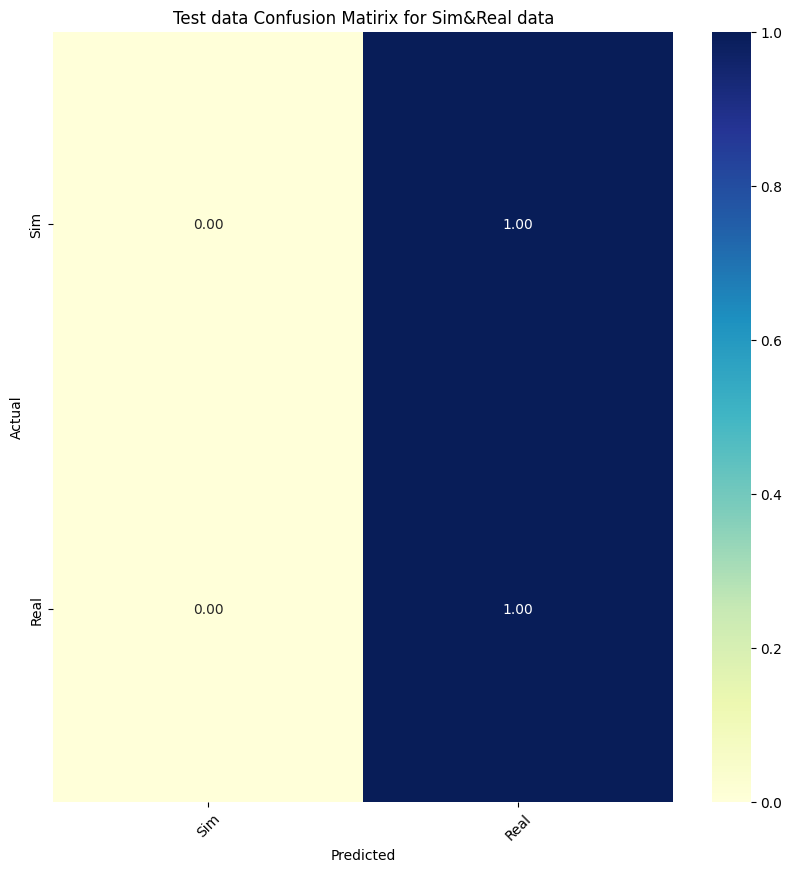


F1 Score: 0.6666666666666666
Precision: 0.5
Recall: 1.0
Accuracy: 0.5


In [23]:
#Test Data Confusion Matirix (SIM & REAL)
#-----------------------------------------------------------------------------------------------------------

predictions_combined = (model.predict(X) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y, predictions_combined)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test data Confusion Matirix for Sim&Real data')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y, predictions_combined, average='binary')))
print('Precision: {}'.format(
    precision_score(y, predictions_combined, average='binary')))
print('Recall: {}'.format(
    recall_score(y, predictions_combined, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y, predictions_combined)))

-------------------------------------
Testing with only fake data

   Run Time  msg  node  topics
0      0.00   19     0       4
1      0.07   27     6       2
2      0.07   29     6       2
3      0.27   15     1       0
4      1.27    9     1       0
0    0
1    0
2    0
3    0
4    0
Name: type, dtype: int64
2/2 [==============================] - 0s 3ms/step
[[ 0 38]
 [ 0  0]] 



<ipython-input-24-3cdc45fbdc03>:34: RuntimeWarning: invalid value encountered in true_divide
  conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


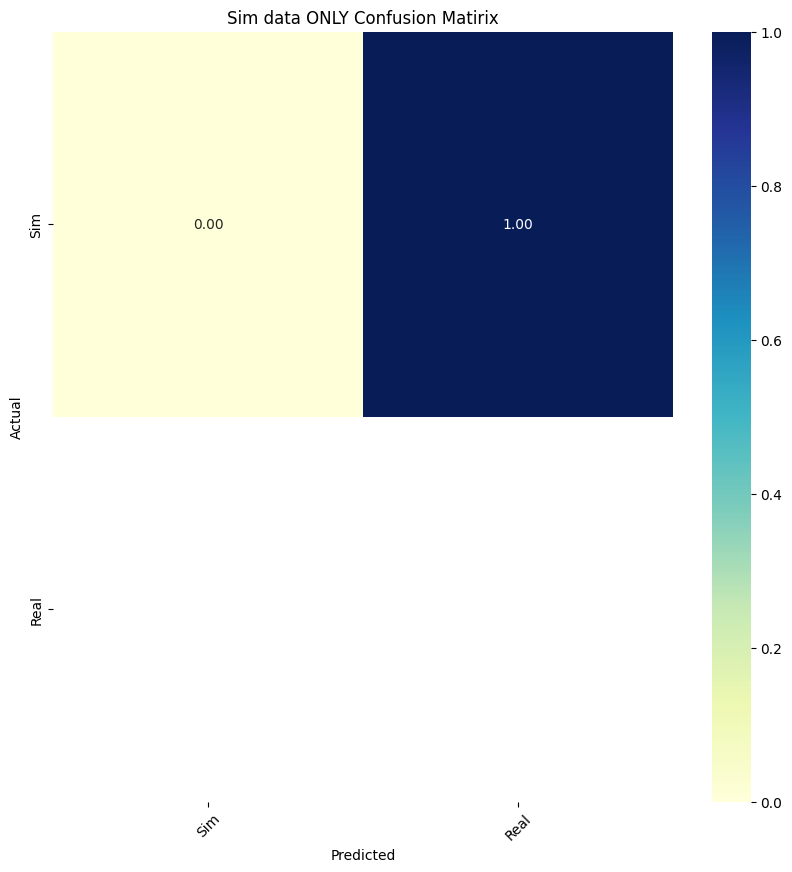


F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
#Outside data model performance (Sim data ONLY)
#----------------------------------------------------------------------------------------------------------
df1 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/mergedata/OldData/blueSIM_test1.csv')
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df1['type'] = 0 #SimData


df1['topics'] = df1['topics'].apply(lambda x: x.replace(" ", ""))
df1


# Encode labels in column 'species'.
df1['topics']= label_encoder.fit_transform(df1['topics'])
df1['msg']= label_encoder.fit_transform(df1['msg'])
df1['node']= label_encoder.fit_transform(df1['node'])
df1

#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df1.drop(predict, axis=1)
y = df1[predict]
print(X.head())
print(y.head())

#Test Data Confusion Matirix (SIM)
#-----------------------------------------------------------------------------------------------------------

predictions_df1 = (model.predict(X) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y, predictions_df1)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Sim data ONLY Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y, predictions_df1, average='binary')))
print('Precision: {}'.format(
    precision_score(y, predictions_df1, average='binary')))
print('Recall: {}'.format(
    recall_score(y, predictions_df1, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y, predictions_df1)))

In [25]:
predictions_df1

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

    Run Time  msg  node  topics
0  290.89665   16     0       0
1  279.95296   21     4       5
2  279.94593   14     0       0
3  263.18176   32     5       2
4  261.81656   10     0       0
0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64
2/2 [==============================] - 0s 4ms/step
[[38]] 



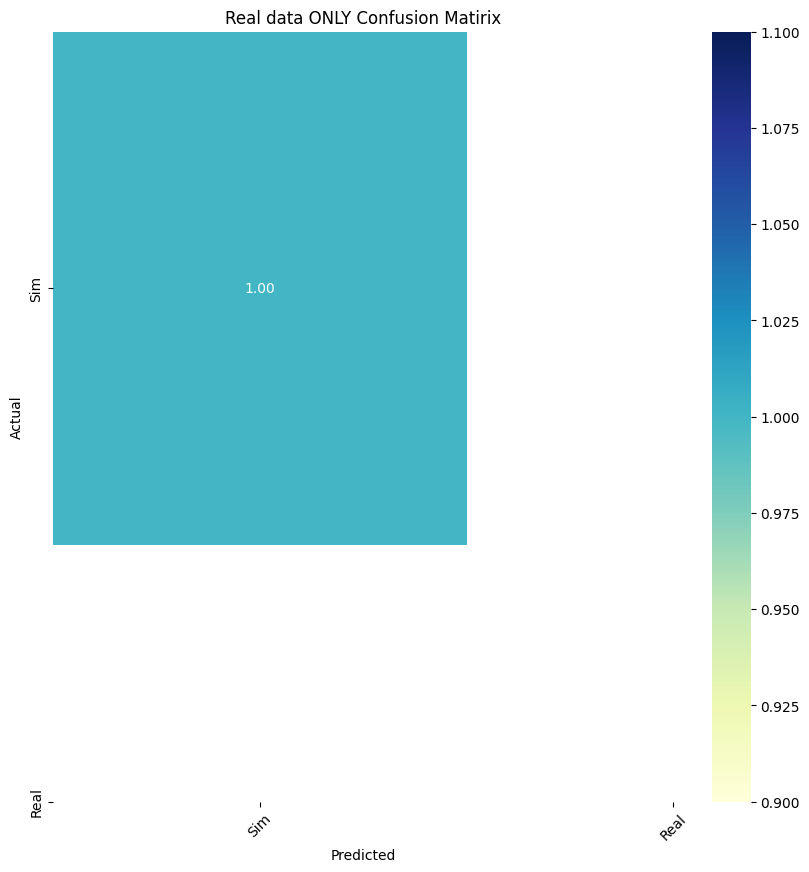


F1 Score: 1.0
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


In [28]:
#Outside data model performance (Real data ONLY)
#----------------------------------------------------------------------------------------------------------
df1 = pd.read_csv('/content/drive/MyDrive/Lab Work/Zach/RealData/Blue Order 2 (Ready4_ML).csv')
df1.rename(columns={'Run Time ': 'Run Time'}, inplace=True)
df1['type'] = 1 #RealData


df1['topics'] = df1['topics'].apply(lambda x: x.replace(" ", ""))
df1


# Encode labels in column 'species'.
df1['topics']= label_encoder.fit_transform(df1['topics'])
df1['msg']= label_encoder.fit_transform(df1['msg'])
df1['node']= label_encoder.fit_transform(df1['node'])
df1

#Setting our prediction target and dropping target columns from the main dataset
predict = 'type'
drops = ['Run Time', 'msg', 'node', 'topics']
X = df1.drop(predict, axis=1)
y = df1[predict]
print(X.head())
print(y.head())

#Test Data Confusion Matirix (REAL)
#-----------------------------------------------------------------------------------------------------------

predictions_df1 = (model.predict(X) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y, predictions_df1)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Sim','Real'], yticklabels=['Sim','Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Real data ONLY Confusion Matirix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y, predictions_df1, average='binary')))
print('Precision: {}'.format(
    precision_score(y, predictions_df1, average='binary')))
print('Recall: {}'.format(
    recall_score(y, predictions_df1, average='binary')))
print('Accuracy: {}'.format(
    accuracy_score(y, predictions_df1)))

In [27]:
predictions_df1

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)